In [36]:
!pip install tppss

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install rioxarray

Defaulting to user installation because normal site-packages is not writeable


In [31]:
!pip install timeout_decorator

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 687.8 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 48.2 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [37]:
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
import rioxarray
import numpy as np
from tppss import horizon, sunrise_sunset, sunrise_sunset_year 
from timeout_decorator import timeout, TimeoutError
import time
import matplotlib.pyplot as plt
from dateutil import tz as dutz
import geopandas as gpd
from rasterio.features import geometry_mask
from shapely.geometry import mapping

In [39]:
file_path = "ETOPO_2022_v1_30s_N90W180_bed.tif"
# file_path = 'new_DEM_constant.tif'
KM = 1000
tz = dutz.gettz()

In [7]:
da = rioxarray.open_rasterio(file_path, crs='EPSG:4326')

In [8]:
elev = da.isel(band=0).values

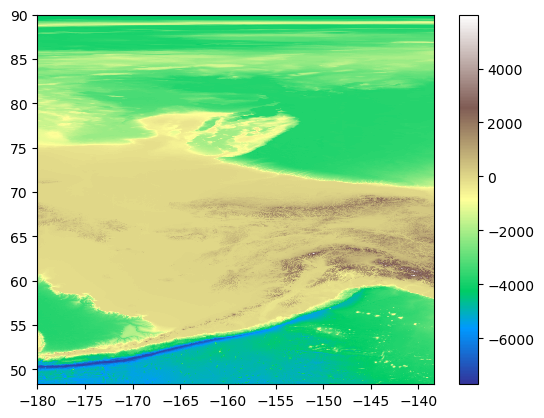

In [12]:
contour_plot = plt.pcolormesh(da.x[:5000], da.y[:5000], elev[:5000, :5000], cmap='terrain')
cbar = plt.colorbar(contour_plot)

In [7]:
def timeout_decorator(seconds, timeout_message="Timeout"):
    def decorator(func):
        def wrapper(*args, **kwargs):
            try:
                result = timeout(seconds)(func)(*args, **kwargs)
                return result
            except TimeoutError:
                print(timeout_message)
                return None

        return wrapper

    return decorator

@timeout_decorator(seconds=4, timeout_message="Timeout occurred in process_location")
def _process_location(latlon, file_path):
    start_time = time.time()    
    try:
        with rasterio.open(file_path) as dataset:
            hor_izon = horizon(latlon, dataset, distance=1*KM, height=0, precision=1)
    except TimeoutError:
        print(f"Timeout for location {latlon}: {time.time()-start_time} seconds")
        return None

    sunsuns = sunrise_sunset_year(latlon, hor_izon, 2022, tz, 20)
    sunsuns_array = np.array(sunsuns)
    daylight_values = []
    for i in range(365):
        day, sunrise, sunset, allday = sunsuns[i]
        if allday:
            delta = 24
        elif allday is None:
            delta = sunset - sunrise
            delta = delta.total_seconds() / 3600
        else:
            delta = 0
        daylight_values.append(delta)

    # daylight_values = np.where(sunsuns_array[:, 3] == True, 24, 
    #                        np.where(sunsuns_array[:, 3] is None, 
    #                                 0,
    #                                 ((sunsuns_array[:, 2] - sunsuns_array[:, 1]).astype('timedelta64[s]')).astype(float) / 3600)
    #                       )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Execution time for location {latlon}: {elapsed_time} seconds")

    return daylight_values

In [8]:
nepal_latlon = (28.969749, 82.984592)

In [9]:
nepal_daylight = _process_location(nepal_latlon, file_path)

Execution time for location (28.969749, 82.984592): 1.917752742767334 seconds


Text(0.5, 1.0, 'Daylight hours in , considering topology')

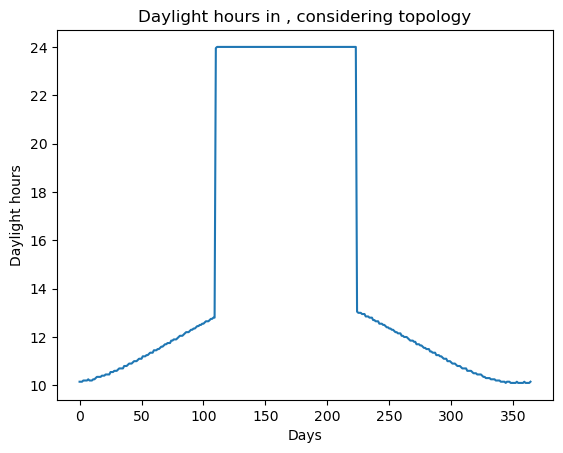

In [12]:
plt.plot(range(365), nepal_daylight)
plt.xlabel('Days')
plt.ylabel('Daylight hours')
plt.ylim(nepal_daylight.values.min(), 24) 
plt.grid(True)
plt.title('Daylight hours in , considering topology')

In [ ]:
'''
Create new DEM with constant elevation
'''

In [20]:
# Load land polygon shapefile
land_polygons = gpd.read_file('shapefiles/ne_10m_land.shp')

In [21]:
# Create a bounding box for the raster
# bbox = land_polygons.total_bounds
bbox = [-180, -90, 180, 90]

In [22]:
# Set the cell size (adjust as needed)
cell_size = 0.01  # Example cell size in degrees

In [23]:
# Create a raster profile
# transform = from_origin(bbox[0], bbox[3], cell_size, cell_size)
# width = int((bbox[2] - bbox[0]) / cell_size)
# height = int((bbox[3] - bbox[1]) / cell_size)

# Calculate the width and height based on the bounding box and cell size
width = int((bbox[2] - bbox[0]) / cell_size)
height = int((bbox[3] - bbox[1]) / cell_size)
# Create a raster profile
transform = from_origin(bbox[0], bbox[3], cell_size, cell_size)
profile = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'width': width,
    'height': height,
    'crs': 'EPSG:4326',
    'transform': transform
}

In [24]:
# Create a raster with constant values on land and 0 in ocean
with rasterio.open('output_dem.tif', 'w', **profile) as dst:
    # Create a mask for land areas
    land_mask = geometry_mask(land_polygons.geometry, transform=dst.transform, invert=True, out_shape=(height, width))
    
    # Set constant value for land and 0 for ocean
    data = np.ones((height, width), dtype=np.float32)
    data[land_mask] = 10 
    
    # Write the data to the raster
    dst.write(data, 1)

In [ ]:
'''
Examine this new file
'''

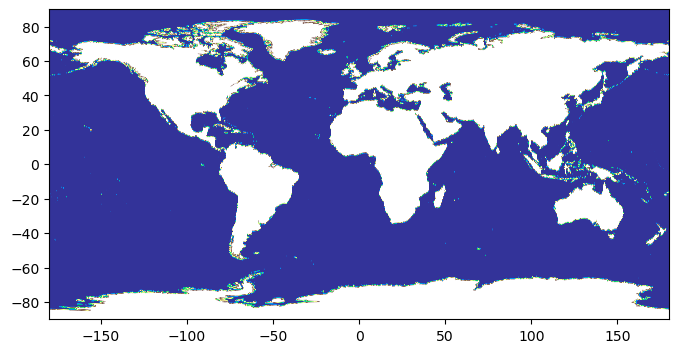

In [61]:
with rasterio.open(file_path) as dataset:
    # Read the raster data for visualization
    data = dataset.read(1)  
    # data = np.nan_to_num(data)

    # Plot the raster data
    plt.figure(figsize=(8, 8))
    show(data, transform=dataset.transform, cmap='terrain')
    # plt.title("GeoTIFF Visualization")
    # plt.show()

In [62]:
file_path = 'output_dem.tif'

In [57]:
nepal_latlon = (28.969749, 82.984592)

In [54]:
nepal_latlon = (46.052361, 8.193722)

In [63]:
nepal_daylight = _process_location(nepal_latlon, file_path)

Execution time for location (28.969749, 82.984592): 1.766934871673584 seconds


Text(0.5, 1.0, 'Daylight hours in , considering topology')

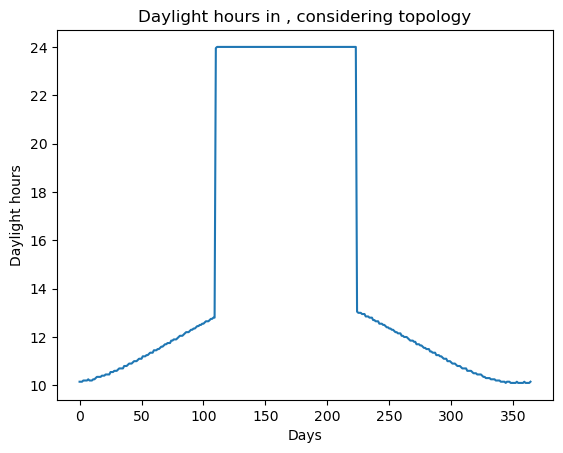

In [64]:
plt.plot(range(365), nepal_daylight)
plt.xlabel('Days')
plt.ylabel('Daylight hours')
plt.title('Daylight hours in , considering topology')